In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

* f é para usar as chavetas {} na string

* convert('L') é para tornas as fotografias greyscale (monocromático)

In [12]:
import glob
images = [glob.glob('yalefaces/ind{}/*'.format(pasta)) for pasta in range(1, 11)]

In [112]:
base = [Image.open(img).convert('L') for pasta in images for img in pasta]

#### "Chama" a imagem

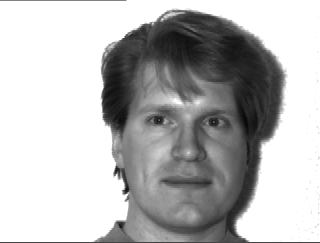

In [19]:
input_img = Image.open(f'yalefaces/ind1/subject01.gif').convert('L')
input_img

#### Saber a quantidade de fotografias que existem

In [20]:
M = len(base)
M

100

#### Gera uma lista de listas em que cada lista corresponde a uma imagem (0 a 399)

In [21]:
X = np.array([base[i].getdata() for i in range(M)])

#### Temos 400 listas em que cada uma 10304 elementos

In [22]:
print(X.shape)
X

(100, 77760)


array([[130, 130, 130, ...,  68,  68,  68],
       [130, 130, 130, ...,  68,  68,  68],
       [130, 130, 130, ...,  68,  68,  68],
       ...,
       [130, 130, 130, ...,  68,  68,  68],
       [130, 130, 130, ...,  68,  68,  68],
       [130, 130, 130, ...,  68,  68,  68]])

#### Centrar o X à média

In [23]:
media = np.mean(X, 0)
phi = X - media

In [24]:
media

array([122.23, 121.94, 122.55, ...,  68.  ,  68.  ,  68.  ])

In [25]:
phi.shape

(100, 77760)

* e_faces : vetores singulares
* sigma : valores singulares
* Não vamos usar o v pelo que metemos como "_"

In [26]:
e_faces, sigma, _ = np.linalg.svd(phi.transpose(), full_matrices = False)

#### Os valores singulares são a raiz de um valor próprio, logo:

In [27]:
val_prop = sigma*sigma

#### Ordenar os valores próprios de forma decrescente

In [28]:
val_prop = np.sort(val_prop)
# o sort dá a lista ordenada crescentemente
# queremos decrescentemente, daí o ::-1
val_prop = val_prop[::-1]

#### Traço da matriz de dispersão (soma de todos valores próprios)

In [29]:
traco = sum(val_prop)

#### Calcular o k consoante a confiança da soma dos k primeiros valores próprios.
* parar quando temos uma confiança mínima de 80%;
* parar quando começar a incrementar menos de 0.5% na confiança.

In [39]:
confianca_alvo = 0.85
k = 0
confianca = 0
confiancaAnt = 0

while confianca < confianca_alvo:
    confiancaAnt = confianca
    confianca = confianca + val_prop[k]/traco
    k += 1
    
    print('(confiança, valor próprio): ({0}, {1})'.format(confianca, k))
        
k, confianca

(confiança, valor próprio): (0.3240635086398956, 1)
(confiança, valor próprio): (0.4952175055610759, 2)
(confiança, valor próprio): (0.5998161998002414, 3)
(confiança, valor próprio): (0.6843819477209767, 4)
(confiança, valor próprio): (0.7198546337542329, 5)
(confiança, valor próprio): (0.7508741249435605, 6)
(confiança, valor próprio): (0.7786787454473534, 7)
(confiança, valor próprio): (0.8029380526398948, 8)
(confiança, valor próprio): (0.8212732668244527, 9)
(confiança, valor próprio): (0.8382094374335526, 10)
(confiança, valor próprio): (0.8510144933433734, 11)


(11, 0.8510144933433734)

#### Vamos ver onde se encontra o nosso k escolhido (método do cotovelo / elbow plot)

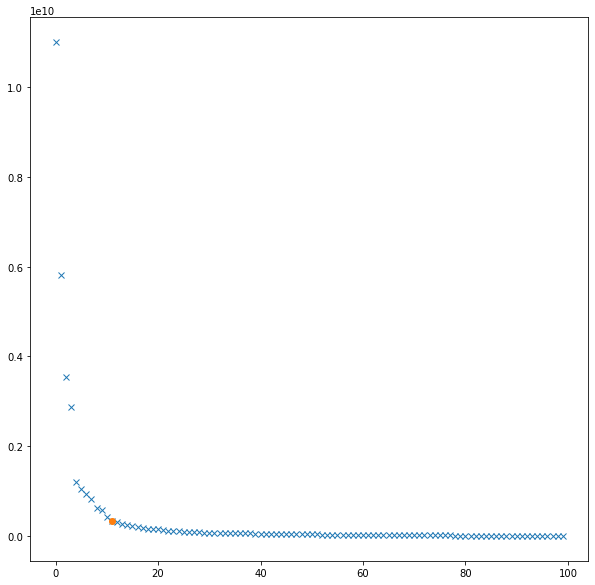

In [40]:
plt.figure(figsize = (10, 10))
t = np.arange(0, M, 1)
plt.plot(t, val_prop, 'x')
plt.plot(k, val_prop[k], 'o')
plt.show()

#### Queremos os k primeiros vetores próprios

In [41]:
newE_Faces = e_faces[:, 0:k]

In [42]:
phi.shape

(100, 77760)

In [43]:
newE_Faces.shape

(77760, 11)

In [44]:
coef_proj = [np.dot(phi[i], newE_Faces) for i in range(M)]

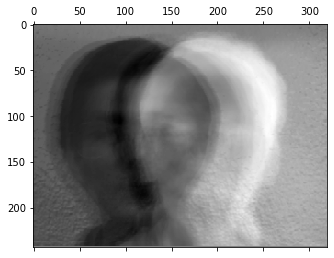

In [62]:
display(plt.matshow(np.reshape(newE_Faces.T[0], (243, 320)), cmap = 'gray'))

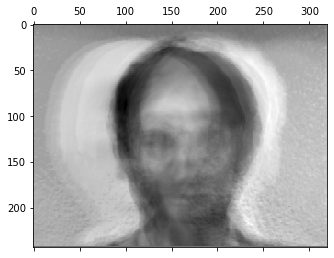

In [63]:
display(plt.matshow(np.reshape(newE_Faces.T[1], (243, 320)), cmap = 'gray'))

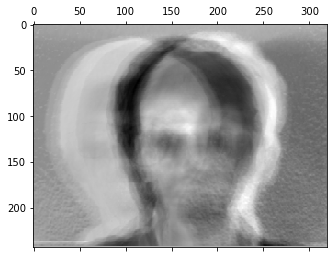

In [64]:
display(plt.matshow(np.reshape(newE_Faces.T[2], (243, 320)), cmap = 'gray'))

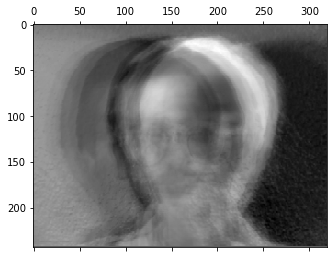

In [65]:
display(plt.matshow(np.reshape(newE_Faces.T[3], (243, 320)), cmap = 'gray'))

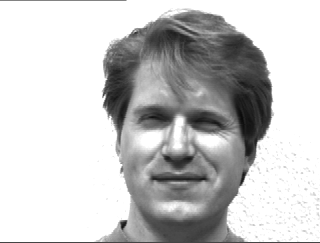

In [89]:
input_img = Image.open(f'yalefaces/teste/subject01.wink').convert('L')
input_img

In [90]:
gamma = np.array(input_img.getdata())

In [91]:
test_phi = gamma - media

In [92]:
test_coef_proj = np.dot(test_phi, newE_Faces)

In [93]:
test_coef_proj.shape

(11,)

In [94]:
def euclidian(coef_proj, test_coef_proj, M):
    dist = [np.linalg.norm(coef_proj[i] - test_coef_proj) for i in range(M)]
    return dist

In [95]:
def mahalanobis(coef_proj, test_coef_proj, val_prop, M):
    dist = [np.sum(np.divide(pow(coef_proj[i] - test_coef_proj, 2), val_prop)) for i in range(M)]
    return dist

In [96]:
dist = euclidian(coef_proj, test_coef_proj, M)
distM = mahalanobis(coef_proj, test_coef_proj, val_prop[:k], M)
d_min = np.min(dist)
print(d_min)
print(np.min(distM))

1662.018130319177
0.0026825548815732157


In [97]:
print(len(dist))
print(len(distM))

100
100


In [98]:
d_min

1662.018130319177

In [99]:
np.argmin(dist)

9

* Falta definir o limite para as duas distâncias quando tivermos as nossas fotos

In [101]:
def recognition(dist, typeDist):
    d_min = np.min(dist)
    
    if typeDist == 'euclidian':
        limite = 3000
    else:
        limite = 0.03
    
    if d_min < limite:
        # como temos 9 imagens por pasta
        pasta = int(np.floor(np.argmin(dist)/10)+1)
        print('Para a distância: ', typeDist)
        print('\tPasta ind'f'{pasta}\n\tdist = {d_min}')
    else:
        print('Falhou no reconhecimento.')

In [104]:
recognition(distM, 'mahalanobis')

Para a distância:  mahalanobis
	Pasta ind1
	dist = 0.0026825548815732157


In [105]:
recognition(dist, 'euclidian')

Para a distância:  euclidian
	Pasta ind1
	dist = 1662.018130319177


In [106]:
def identifyImage(img, typeDist):
    gamma = np.array(img.getdata())
    test_phi = gamma - media
    test_coef_proj = np.dot(test_phi, newE_Faces)
    
    if typeDist == 'euclidian':
        dist = euclidian(coef_proj, test_coef_proj, M)
    elif typeDist == 'mahalanobis':
        dist = mahalanobis(coef_proj, test_coef_proj, val_prop[:k], M)
    else:
        print('Something went wrong :(')
        return
    
    recognition(dist, typeDist)
    return test_coef_proj[0:2]

In [107]:
def identify(img):
    gamma = np.array(img.getdata())
    test_phi = gamma - media
    test_coef_proj = np.dot(test_phi, newE_Faces)
    return test_coef_proj[0:2]

In [110]:
identifyImage(Image.open(f'yalefaces/teste/subject03.wink').convert('L'), 'mahalanobis')

Para a distância:  mahalanobis
	Pasta ind3
	dist = 0.0018551110462934786


array([2597.90886539, 8941.65099411])

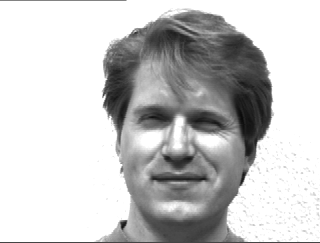

In [111]:
Image.open(f'yalefaces/teste/subject01.wink').convert('L')

Text(0, 0.5, 'Eigenface 2')

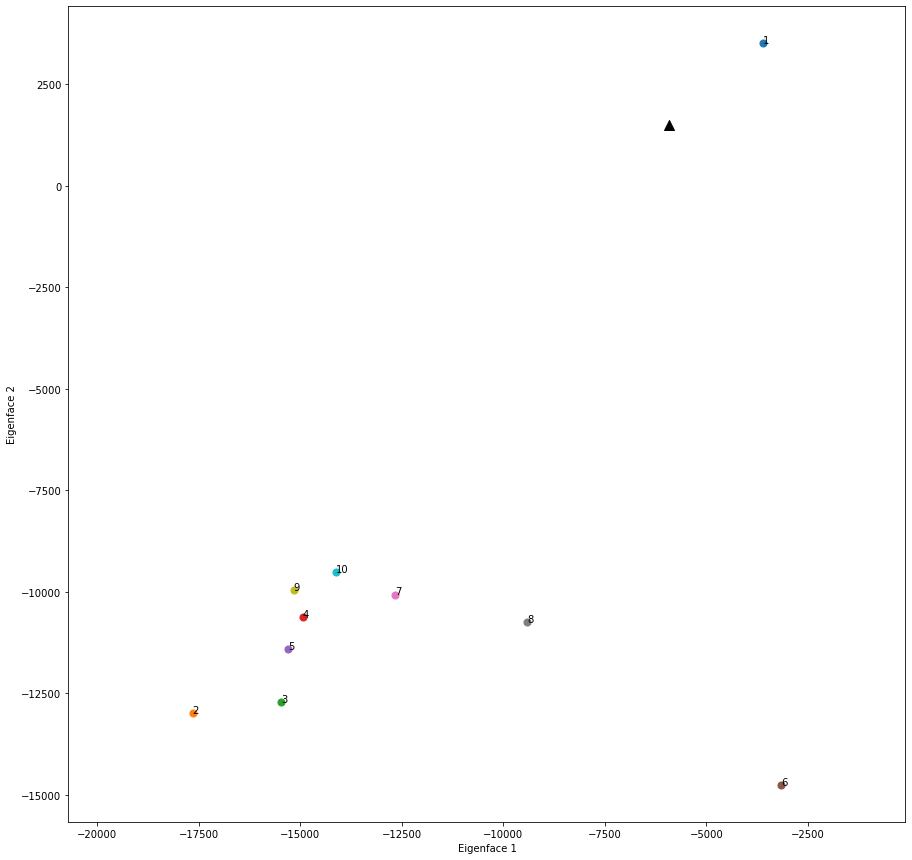

In [128]:
plt.figure(figsize = (15, 15))
plt.axis('equal')
for pasta in range(1, 11):
    images = glob.glob('yalefaces/ind{}/*'.format(pasta))
    images = images[3:4]
    imagens = [Image.open(img).convert('L') for img in images]
    x, y = np.array([identify(pic) for pic in imagens]).T
    plt.scatter(x, y, s = 50)
    plt.text(x, y, pasta)
plt.scatter(*identify(input_img), label = 'Input image', marker = '^', c = 'k', s = 100)
plt.xlabel('Eigenface 1')
plt.ylabel('Eigenface 2')

In [131]:
images = glob.glob('yalefaces/teste/*')
realPersons = [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 11, 11, 11,
              12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14,
              15, 15, 15, 15]
i = 0
for image in images:
    identifyImage(Image.open(image).convert('L'), 'euclidian')
    print('\treal person: ', realPersons[i],'\n')
    i += 1

Para a distância:  euclidian
	Pasta ind1
	dist = 1555.4030962683066
	real person:  1 

Para a distância:  euclidian
	Pasta ind1
	dist = 1662.018130319177
	real person:  1 

Para a distância:  euclidian
	Pasta ind2
	dist = 2679.5183194658284
	real person:  2 

Para a distância:  euclidian
	Pasta ind3
	dist = 1214.0592979938965
	real person:  3 

Para a distância:  euclidian
	Pasta ind4
	dist = 1308.8307999529713
	real person:  4 

Para a distância:  euclidian
	Pasta ind5
	dist = 626.2581170802194
	real person:  5 

Para a distância:  euclidian
	Pasta ind6
	dist = 1313.9690374606741
	real person:  6 

Para a distância:  euclidian
	Pasta ind7
	dist = 2139.320006002232
	real person:  7 

Falhou no reconhecimento.
	real person:  8 

Falhou no reconhecimento.
	real person:  9 

Para a distância:  euclidian
	Pasta ind10
	dist = 1588.2538899703347
	real person:  10 

Falhou no reconhecimento.
	real person:  11 

Falhou no reconhecimento.
	real person:  11 

Falhou no reconhecimento.
	real pers

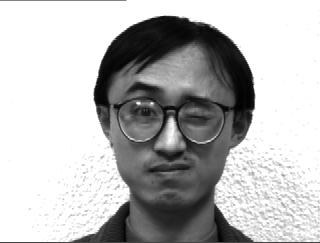

In [132]:
Image.open(f'yalefaces/teste/subject08.wink').convert('L')

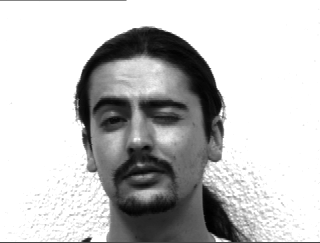

In [133]:
Image.open(f'yalefaces/teste/subject09.wink').convert('L')

In [134]:
images = glob.glob('yalefaces/teste/*')
realPersons = [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 11, 11, 11,
              12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14,
              15, 15, 15, 15]
i = 0
for image in images:
    identifyImage(Image.open(image).convert('L'), 'mahalanobis')
    print('\treal person: ', realPersons[i],'\n')
    i += 1

Para a distância:  mahalanobis
	Pasta ind1
	dist = 0.001262126718371104
	real person:  1 

Para a distância:  mahalanobis
	Pasta ind1
	dist = 0.0026825548815732157
	real person:  1 

Para a distância:  mahalanobis
	Pasta ind2
	dist = 0.0070832294457229515
	real person:  2 

Para a distância:  mahalanobis
	Pasta ind3
	dist = 0.0018551110462934786
	real person:  3 

Para a distância:  mahalanobis
	Pasta ind4
	dist = 0.002173442452423218
	real person:  4 

Para a distância:  mahalanobis
	Pasta ind5
	dist = 0.00032416412451060056
	real person:  5 

Para a distância:  mahalanobis
	Pasta ind6
	dist = 0.0019790895434516976
	real person:  6 

Para a distância:  mahalanobis
	Pasta ind7
	dist = 0.006591990956872196
	real person:  7 

Falhou no reconhecimento.
	real person:  8 

Para a distância:  mahalanobis
	Pasta ind9
	dist = 0.006284386617213485
	real person:  9 

Para a distância:  mahalanobis
	Pasta ind10
	dist = 0.0022792463791310703
	real person:  10 

Falhou no reconhecimento.
	real pers